# Bayes ngram approach for genre classification for ukrpravda corpus
## Mixed POS-punctuation ngrams as a baseline¶

In [1]:
from articlehelper import ArticleHandler, RePostprocessor, map_paragraphs, map_category_ukrpravda
import numpy as np
import pandas as pd
from clfhelpers import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, mutual_info_score, adjusted_mutual_info_score, accuracy_score
from analyzers import PosAnalyzer, PosFreqWordsAnalyzer, Morphology, PosLexAnalyzer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_classif

MASK = "data\\news"
zip_fname = MASK + '.zip'
train_fname = MASK + '_train.txt'
test_fname = MASK + '_test.txt'

In [2]:
train = ArticleHandler.read_zip_list(zip_fname, train_fname) 
print(len(train))
test = ArticleHandler.read_zip_list(zip_fname, test_fname)
print(len(test))

2250
750


In [3]:
df_train = pd.DataFrame.from_dict(map_paragraphs(train, map_category_ukrpravda))
df_train.groupby(['category']).count()


,doc,text
category,,
articles,15584,15584
blog,10150,10150
columns,11328,11328
news,10900,10900


In [4]:
df_test = pd.DataFrame.from_dict(map_paragraphs(test, map_category_ukrpravda))
for doc in test:
    doc['category'] = map_category_ukrpravda(doc)
   

In [20]:
df_test.groupby(['category']).count()

,doc,text
category,,
articles,4828,4828
blog,3235,3235
columns,4092,4092
news,3832,3832


In [21]:
X_train = df_train['text'].values
X_test = df_test['text'].values
y_train = df_train['category'].values
y_test = df_test['category'].values

In [22]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

47962 15987 47962 15987


In [23]:
class ClfFactoryPOS:
    def get_analyzer(self):
        return PosAnalyzer.analyze
    
    def make_classifier(self):
        return MultinomialNB(alpha=0.05)
    
    def make_vectorizer(self):
        return TfidfVectorizer(tokenizer=self.get_analyzer(), ngram_range=(2, 4), min_df=10)

factory = ClfFactoryPOS()
s = X_train[0] +'\n'+ X_train[1]
print(s)
print(factory.get_analyzer()(s))   

Після річної перерви в Україні стартували публічні закупівлі енергосервісу.
У листопаді пошук видає 81 оголошення про закупівлі цієї послуги для комунальних установ Київської, Сумської та Миколаївської областей.
['<P>', '<P>', '<P>', 'ADVB', 'ADJF', 'NOUN', 'PREP', 'NOUN', 'VERB', 'ADJF', 'NOUN', 'NOUN', '.', '</P>', '</P>', '</P>', '<P>', '<P>', '<P>', 'PREP', 'NOUN', 'NOUN', 'VERB', 'NUMBER', 'NOUN', 'NOUN', 'NOUN', 'NPRO', 'NOUN', 'PREP', 'ADJF', 'NOUN', 'ADJF', ',', 'ADJF', 'CONJ', 'ADJF', 'NOUN', '.', '</P>', '</P>', '</P>']


In [24]:
tfidf = factory.make_vectorizer()
clf = factory.make_classifier()

vtrain = tfidf.fit_transform(X_train)
vtest = tfidf.transform(X_test)

In [25]:
print(vtrain.shape, vtest.shape)

(47962, 18120) (15987, 18120)


In [26]:
clf.fit(vtrain, y_train)
y_predicted = clf.predict(vtest)
print(classification_report(y_test, y_predicted, clf.classes_))
print('Adjusted mutual info score: ', adjusted_mutual_info_score(y_test, y_predicted))
print('Accuracy score: ', accuracy_score(y_test, y_predicted))

             precision    recall  f1-score   support

   articles       0.47      0.58      0.52      4828
       blog       0.54      0.39      0.45      3235
    columns       0.46      0.38      0.41      4092
       news       0.66      0.74      0.69      3832

avg / total       0.52      0.53      0.52     15987

Adjusted mutual info score:  0.1612238132864529
Accuracy score:  0.5259273159442047


In [13]:
show_all_top_features(tfidf, clf, n=40)

articles:
NOUN NOUN: -4.956149183307669
<P> <P>: -5.123331901747159
</P> </P>: -5.123331901747159
ADJF NOUN: -5.171509611318108
NOUN ,: -5.419911353153296
NOUN .: -5.566648648936145
PREP NOUN: -5.578238303671445
VERB NOUN: -5.597205494122717
NOUN VERB: -5.654224464510208
NPRO NOUN: -5.802253690933879
<P> <P> <P>: -5.816414595792163
</P> </P> </P>: -5.816414595792163
NOUN ADJF: -5.8198426826390355
NOUN PREP: -5.820613157464931
NOUN NOUN NOUN: -5.879781688333703
, CONJ: -5.8954847347543735
NPRO VERB: -5.907022217377523
. </P> </P> </P>: -5.907930661381571
. </P> </P>: -5.907930661381571
. </P>: -5.907930661381571
PRCL VERB: -6.003788715491305
NOUN . </P> </P>: -6.014071890504556
NOUN . </P>: -6.014071890504556
NOUN ": -6.046984976505712
CONJ NOUN: -6.070513564024436
NOUN ADJF NOUN: -6.073047159512261
NOUN PREP NOUN: -6.1243539814932655
NOUN CONJ: -6.142679982316664
VERB ,: -6.235435885224367
VERB ADJF: -6.263477279732965
ADJF NOUN .: -6.264619196022611
, NOUN: -6.2703757221956895
PREP AD

In [27]:
percentile = 60
sel_perc = SelectPercentile(mutual_info_classif, percentile)
vtrain_perc = sel_perc.fit_transform(vtrain, y_train)
vtest_perc = sel_perc.transform(vtest)

             precision    recall  f1-score   support

   articles       0.46      0.60      0.52      4828
       blog       0.53      0.38      0.44      3235
    columns       0.46      0.36      0.40      4092
       news       0.66      0.72      0.69      3832

avg / total       0.52      0.52      0.51     15987

Adjusted mutual info score:  0.1568549485993358
Accuracy score:  0.5223619190592357


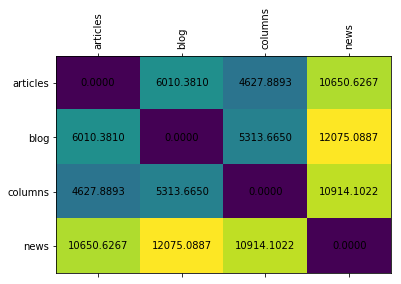

In [28]:
clf.fit(vtrain_perc, y_train)
y_predicted = clf.predict(vtest_perc)
print(classification_report(y_test, y_predicted, clf.classes_))
print('Adjusted mutual info score: ', adjusted_mutual_info_score(y_test, y_predicted))
print('Accuracy score: ', accuracy_score(y_test, y_predicted))
plot_clf_classes_distances(clf)

In [29]:
show_all_top_features(tfidf, clf, n=40)

articles:
ADJF VERB PREP: -4.900654771578256
, PRED NOUN: -5.067362984353313
, PRCL NUMBER NOUN: -5.067362984353313
. NPRO UNDEF NOUN: -5.116047238784185
ADJF ADJF VERB PRCL: -5.364489942541424
ADJF NOUN ) UNDEF: -5.511129021504041
INTJ NUMBER %: -5.522487113508764
NOUN COMP , CONJ: -5.541656132944205
ADVB NUMBER NUMBER NOUN: -5.598973408395065
COMP VERB ,: -5.746503425952572
, PREP ADJF PREP: -5.760445585019666
, PRCL NUMBER VERB: -5.760445585019666
ADJF NOUN PRCL ): -5.7641723975905235
ADVB NOUN : ": -5.765063693154505
ADVB - ADJF: -5.82450555202761
" [ NUMBER ,: -5.840581188599441
CONJ COMP .: -5.851253880357344
, CONJ NPRO ,: -5.852542800517419
, CONJ NPRO ": -5.852542800517419
, CONJ NPRO: -5.852542800517419
INTJ ADJF , CONJ: -5.947696377636806
ADJF NOUN , CONJ: -5.958539268279675
ADJF NOUN , COMP: -5.958539268279675
ADJF . ADJF VERB: -5.99081068105279
<P> NOUN NPRO PRCL: -6.014973278985336
ADJF NOUN VERB .: -6.017462674100435
ADVB NOUN INTJ: -6.068661492924392
ADJF PREP NOUN PREP

In [30]:
for doc in test:
    doc['category'] = map_category_ukrpravda(doc)
df_test = pd.DataFrame.from_dict(test)
df_test.groupby(['category']).count()

,authors,authors_description,autocategory,body,date,filename,language,tags,text,title,url
category,,,,,,,,,,,
articles,37,0,88,88,34,88,88,24,88,33,88
blog,150,150,150,150,150,150,150,150,150,150,150
columns,36,0,112,112,76,112,112,42,112,51,112
news,0,0,400,400,384,400,400,365,400,384,400


In [31]:
X_test = df_test['text'].values
y_test = df_test['category']
vtest = tfidf.transform(X_test)
vtest_perc = sel_perc.transform(vtest)
y_predicted = clf.predict(vtest_perc.toarray())
print(classification_report(y_test, y_predicted, clf.classes_))
print('Adjusted mutual info score: ', adjusted_mutual_info_score(y_test, y_predicted))
print('Accuracy score: ', accuracy_score(y_test, y_predicted))

             precision    recall  f1-score   support

   articles       0.45      0.78      0.57        88
       blog       0.98      0.53      0.69       150
    columns       0.72      0.77      0.74       112
       news       0.97      0.96      0.97       400

avg / total       0.88      0.83      0.83       750

Adjusted mutual info score:  0.6051237638958282
Accuracy score:  0.828


In [19]:
# from sklearn.externals import joblib
# joblib.dump(clf, 'clf_news_MNB_POS.pkl') 
# joblib.dump(tfidf, 'tfidf_news_MNB_POS.pkl')
# joblib.dump(sel_perc, 'featsel_news_MNB_POS.pkl')

## Mixed POS-punctuation-frequent words ngrams

In [8]:
class ClfFactoryMix:
    def __init__(self, analyzer=PosFreqWordsAnalyzer(Morphology().getAnalyzer())):
        self.analyzer = analyzer
    
    def get_analyzer(self):
        return self.analyzer.analyze
    
    def make_classifier(self):
        return MultinomialNB(alpha=0.05)
    
    def make_vectorizer(self):
        return TfidfVectorizer(tokenizer=self.get_analyzer(), ngram_range=(2, 4), min_df=10)

freq_words = pd.read_csv('data\\freq_words.txt', sep=' ', header=None, names=['word', 'freq'])['word'].values
print(freq_words)
factory = ClfFactoryMix(PosFreqWordsAnalyzer(Morphology().getAnalyzer(), list(freq_words)))
s = X_train[0] +'\n'+ X_train[1]
print(s)
print(factory.get_analyzer()(s))  

Morphology initialized for uk
['в' 'на' 'і' ... 'середньої' 'доля' 'сподівається']
Після річної перерви в Україні стартували публічні закупівлі енергосервісу.
У листопаді пошук видає 81 оголошення про закупівлі цієї послуги для комунальних установ Київської, Сумської та Миколаївської областей.
['<P>', '<P>', '<P>', 'після', 'ADJF', 'NOUN', 'в', 'NOUN', 'VERB', 'ADJF', 'NOUN', 'NOUN', '.', '</P>', '</P>', '</P>', '<P>', '<P>', '<P>', 'у', 'листопаді', 'NOUN', 'VERB', 'NUMBER', 'NOUN', 'про', 'NOUN', 'цієї', 'NOUN', 'для', 'ADJF', 'NOUN', 'ADJF', ',', 'ADJF', 'та', 'ADJF', 'NOUN', '.', '</P>', '</P>', '</P>']


In [14]:
tfidf = factory.make_vectorizer()
clf = factory.make_classifier()

vtrain = tfidf.fit_transform(X_train)
vtest = tfidf.transform(X_test)

In [15]:
clf.fit(vtrain, y_train)
y_predicted = clf.predict(vtest)
print(classification_report(y_test, y_predicted, clf.classes_))
print('Adjusted mutual info score: ', adjusted_mutual_info_score(y_test, y_predicted))
print('Accuracy score: ', accuracy_score(y_test, y_predicted))

             precision    recall  f1-score   support

   articles       0.51      0.63      0.56      4828
       blog       0.57      0.49      0.52      3235
    columns       0.52      0.46      0.48      4092
       news       0.79      0.76      0.77      3832

avg / total       0.59      0.59      0.59     15987

0.23053908734106315


In [16]:
print(clf.coef_.shape)

(4, 40167)


In [17]:
print(accuracy_score(y_test, y_predicted))

0.5872896728591981


In [18]:
percentile = 70
sel_perc = SelectPercentile(mutual_info_classif, percentile)
vtrain_perc = sel_perc.fit_transform(vtrain, y_train)
vtest_perc = sel_perc.transform(vtest)

             precision    recall  f1-score   support

   articles       0.50      0.64      0.56      4828
       blog       0.57      0.47      0.51      3235
    columns       0.52      0.45      0.48      4092
       news       0.78      0.74      0.76      3832

avg / total       0.59      0.58      0.58     15987

0.22149324559376657


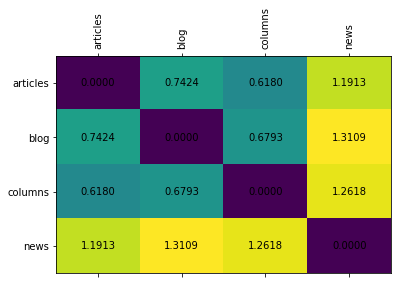

In [19]:
clf.fit(vtrain_perc, y_train)
y_predicted = clf.predict(vtest_perc)
print(classification_report(y_test, y_predicted, clf.classes_))
print('Adjusted mutual info score: ', adjusted_mutual_info_score(y_test, y_predicted))
print('Accuracy score: ', accuracy_score(y_test, y_predicted))
plot_clf_classes_distances(clf)

In [23]:
df_test_doc = pd.DataFrame.from_dict(test)
X_test = df_test_doc['text'].values
y_test = df_test_doc['category']
vtest = tfidf.transform(X_test)
vtest_perc = sel_perc.transform(vtest)
y_predicted = clf.predict(vtest_perc.toarray())
print('Adjusted mutual info score: ', adjusted_mutual_info_score(y_test, y_predicted))
print('Accuracy score: ', accuracy_score(y_test, y_predicted))

Adjusted mutual info score:  0.6822170161819956
Accuracy score:  0.8626666666666667
0.8626666666666667


In [24]:
print(clf.coef_.shape)

(4, 28117)


In [25]:
show_all_top_features(tfidf, clf, n=100)

articles:
- NOUN " ,: -4.934072933155205
, і є: -4.934072933155205
ADJF NOUN стало: -5.177341400626325
<P> <P> UNDEF ADVB: -5.183972428950127
<P> чи: -5.365225177013889
ADJF NOUN , та: -5.477071753804951
- NOUN ADVB: -5.6271527924459495
, і їх: -5.6271527924459495
, то NOUN: -5.7316623307418775
, то ADVB: -5.7316623307418775
, то ADJF NOUN: -5.7316623307418775
NOUN VERB не: -5.89372883203987
ADJF NOUN , тобто: -5.91608357988122
ADJF NOUN , то: -5.91608357988122
<P> про це на: -5.9201450576834445
ADJF шляхом: -5.923080645102058
ADJF NOUN всіх NOUN: -5.972224285594443
. тим ADVB: -6.2272126783829895
. NOUN , ADJF: -6.2272126783829895
- NOUN VERB ADJF: -6.2272126783829895
<P> <P> вважаю: -6.2341711423075825
, ввечері: -6.243205480892995
NOUN UNDEF до NOUN: -6.24748628681213
( тобто: -6.250043037611336
. не знаю: -6.2612130501276235
. </P> </P>: -6.2612130501276235
- NOUN NUMBER: -6.2612130501276235
ADJF NOUN з UNDEF: -6.289826014847831
ADJF VERB до NOUN: -6.310081102783192
ADJF рішення NO

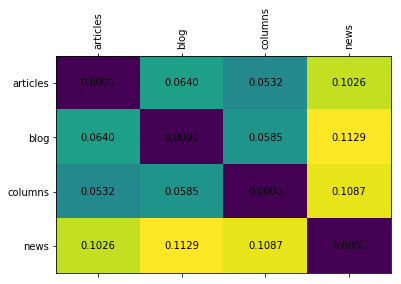

In [30]:
plot_clf_classes_distances(clf, metric='l1', normalization='sum')

### Use lemmatization - for better results

In [9]:
freq_words = pd.read_csv('data\\freq_words.txt', sep=' ', header=None, names=['word', 'freq'])['word'].values
print(freq_words)
factory = ClfFactoryMix(PosFreqWordsAnalyzer(Morphology().getAnalyzer(), list(freq_words), lemmatize_freq = True))
s = X_train[0] +'\n'+ X_train[1]
print(s)
print(factory.get_analyzer()(s))  

['в' 'на' 'і' ... 'середньої' 'доля' 'сподівається']
Після річної перерви в Україні стартували публічні закупівлі енергосервісу.
У листопаді пошук видає 81 оголошення про закупівлі цієї послуги для комунальних установ Київської, Сумської та Миколаївської областей.
['<P>', '<P>', '<P>', 'після', 'ADJF', 'NOUN', 'в', 'NOUN', 'VERB', 'ADJF', 'NOUN', 'NOUN', '.', '</P>', '</P>', '</P>', '<P>', '<P>', '<P>', 'у', 'листопад', 'NOUN', 'VERB', 'NUMBER', 'NOUN', 'про', 'NOUN', 'цей', 'послуга', 'для', 'ADJF', 'NOUN', 'ADJF', ',', 'ADJF', 'та', 'ADJF', 'область', '.', '</P>', '</P>', '</P>']


In [10]:
tfidf = factory.make_vectorizer()
clf = factory.make_classifier()

vtrain = tfidf.fit_transform(X_train)
vtest = tfidf.transform(X_test)

In [12]:
clf.fit(vtrain, y_train)
y_predicted = clf.predict(vtest)
print(classification_report(y_test, y_predicted, clf.classes_))
print('Adjusted mutual info score: ', adjusted_mutual_info_score(y_test, y_predicted))
print('Accuracy score: ', accuracy_score(y_test, y_predicted))

             precision    recall  f1-score   support

   articles       0.52      0.64      0.57      4828
       blog       0.58      0.49      0.53      3235
    columns       0.52      0.45      0.48      4092
       news       0.79      0.78      0.78      3832

avg / total       0.60      0.59      0.59     15987

Adjusted mutual info score:  0.23879673210118432
Accuracy score:  0.5927315944204666


In [13]:
percentile = 70
sel_perc = SelectPercentile(mutual_info_classif, percentile)
vtrain_perc = sel_perc.fit_transform(vtrain, y_train)
vtest_perc = sel_perc.transform(vtest)

             precision    recall  f1-score   support

   articles       0.51      0.65      0.57      4828
       blog       0.59      0.48      0.53      3235
    columns       0.52      0.45      0.48      4092
       news       0.80      0.76      0.78      3832

avg / total       0.60      0.59      0.59     15987

Adjusted mutual info score:  0.2345509083748942
Accuracy score:  0.5909176205667105


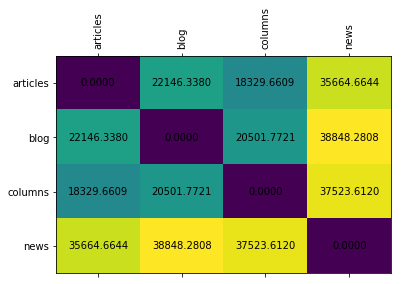

In [14]:
clf.fit(vtrain_perc, y_train)
y_predicted = clf.predict(vtest_perc)
print(classification_report(y_test, y_predicted, clf.classes_))
print('Adjusted mutual info score: ', adjusted_mutual_info_score(y_test, y_predicted))
print('Accuracy score: ', accuracy_score(y_test, y_predicted))
plot_clf_classes_distances(clf)

In [15]:
df_test_doc = pd.DataFrame.from_dict(test)
X_test = df_test_doc['text'].values
y_test = df_test_doc['category']
vtest = tfidf.transform(X_test)
vtest_perc = sel_perc.transform(vtest)
y_predicted = clf.predict(vtest_perc.toarray())
print('Adjusted mutual info score: ', adjusted_mutual_info_score(y_test, y_predicted))
print('Accuracy score: ', accuracy_score(y_test, y_predicted))

Adjusted mutual info score:  0.675944585157591
Accuracy score:  0.864


In [16]:
print(clf.coef_.shape)

(4, 29476)


# Using stylistic bigrams

In [7]:
class ClfFactoryPosLex:
    def __init__(self, analyzer = None, pwf_analyzer=PosFreqWordsAnalyzer(Morphology().getAnalyzer(), lemmatize_freq = True), 
                 lexngrams = None, ngramsize = 2):
        if analyzer is None:
            self.analyzer = PosLexAnalyzer(pwf_analyzer, lexngrams, ngramsize)
        else:
            self.analyzer = analyzer
    
    def get_analyzer(self):
        return self.analyzer.analyze
    
    def make_classifier(self):
        return MultinomialNB(alpha=0.05)
    
    def make_vectorizer(self):
        return TfidfVectorizer(tokenizer=self.get_analyzer(), ngram_range=(2, 4), min_df=10)

freq_words = pd.read_csv('data\\freq_words.txt', sep=' ', header=None, names=['word', 'freq'])['word'].values
lexngrams = np.loadtxt('data\\news_bigrams.txt', dtype=object, encoding='utf-8')
print('Lexical ngrams count:', len(lexngrams))
factory = ClfFactoryPosLex(None, PosFreqWordsAnalyzer(Morphology().getAnalyzer(), list(freq_words), lemmatize_freq=True), lexngrams)
s = X_train[0] +'\n'+ X_train[1]
print(s)
print(factory.get_analyzer()(s))  

Morphology initialized for uk
Lexical ngrams count: 13099
Після річної перерви в Україні стартували публічні закупівлі енергосервісу.
У листопаді пошук видає 81 оголошення про закупівлі цієї послуги для комунальних установ Київської, Сумської та Миколаївської областей.
['<P>', '<P>', '<P>', 'після', 'ADJF', 'NOUN', 'в', 'NOUN', 'VERB', 'ADJF', 'NOUN', 'NOUN', '.', '</P>', '</P>', '</P>', '<P>', '<P>', '<P>', 'у', 'листопад', 'NOUN', 'VERB', 'NUMBER', 'оголошення', 'про', 'NOUN', 'цей', 'послуга', 'для', 'ADJF', 'NOUN', 'ADJF', ',', 'ADJF', 'та', 'ADJF', 'область', '.', '</P>', '</P>', '</P>']


In [8]:
tfidf = factory.make_vectorizer()
clf = factory.make_classifier()

vtrain = tfidf.fit_transform(X_train)
vtest = tfidf.transform(X_test)

In [9]:
clf.fit(vtrain, y_train)
y_predicted = clf.predict(vtest)
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))
print(accuracy_score(y_test, y_predicted))

             precision    recall  f1-score   support

   articles       0.52      0.67      0.59      4828
       blog       0.62      0.53      0.57      3235
    columns       0.55      0.46      0.50      4092
       news       0.82      0.77      0.79      3832

avg / total       0.62      0.61      0.61     15987

0.25802677204264707
0.6107462313129418


In [10]:
print(clf.coef_.shape)

(4, 45075)


In [11]:
percentile = 80
sel_perc = SelectPercentile(mutual_info_classif, percentile)
vtrain_perc = sel_perc.fit_transform(vtrain, y_train)

In [12]:
vtest_perc = sel_perc.transform(vtest)

             precision    recall  f1-score   support

   articles       0.52      0.67      0.58      4828
       blog       0.61      0.52      0.56      3235
    columns       0.54      0.45      0.49      4092
       news       0.82      0.76      0.79      3832

avg / total       0.62      0.61      0.61     15987

0.2526367466972098
0.6061800212672797


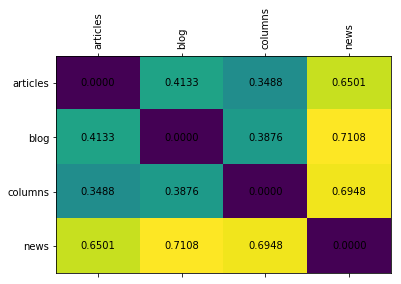

In [13]:
clf.fit(vtrain_perc, y_train)
y_predicted = clf.predict(vtest_perc)
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))
print(accuracy_score(y_test, y_predicted))
plot_clf_classes_distances(clf, normalization='dim')

In [14]:
print(clf.coef_.shape)

(4, 36060)


**Top 40 features**

In [15]:
show_all_top_features(tfidf, clf, n=40)

articles:
. UNDEF т .: -4.892691537403236
. NOUN повинний: -4.8941025923086094
ADJF підхід .: -5.341220360468798
<P> ADVB ,: -5.484519074023599
. NOUN про: -5.584592919471986
. а тут: -5.585771564024707
ADJF и: -5.664659856878717
ADJF автомобіль .: -5.681664681561908
, що свій: -5.686244470862192
, що свідчити про: -5.686244470862192
, що свідчити: -5.686244470862192
ADJF його: -6.082164650847136
ADJF й ADJF NOUN: -6.082164650847136
ADJF NOUN полягати: -6.105343238675907
ADJF орган: -6.148962574569465
NOUN могти бути: -6.162052396083279
, не дивлячись на: -6.180949791532867
<P> <P> <P> натомість: -6.182724484893696
. от тільки: -6.182724484893696
. але ,: -6.182724484893696
ADVB підтвердити: -6.185441538893533
ADVB NOUN NOUN NOUN: -6.356567010817028
<P> <P> <P> ви: -6.364743637425363
. наприклад ,: -6.364743637425363
. адже ADJF: -6.364743637425363
) в NOUN: -6.380752305959382
" ADJF ADVB: -6.411586717012637
, себто: -6.493713380077834
ADJF система VERB: -6.571767006212352
NUMBER грн <

In [16]:
from sklearn.externals import joblib
# joblib.dump(clf, 'saves\\clf_news_MNB_poslex.pkl') 
# joblib.dump(tfidf, 'saves\\tfidf_news_MNB_poslex.pkl')
# joblib.dump(sel_perc, 'saves\\featsel_news_MNB_poslex.pkl')

In [17]:
df_test_doc = pd.DataFrame.from_dict(test)
X_test = df_test_doc['text'].values
y_test = df_test_doc['category']
vtest = tfidf.transform(X_test)
vtest_perc = sel_perc.transform(vtest)
y_predicted = clf.predict(vtest_perc.toarray())
print(classification_report(y_test, y_predicted, clf.classes_))
print('Adjusted mutual info score: ', adjusted_mutual_info_score(y_test, y_predicted))
print('Accuracy score: ', accuracy_score(y_test, y_predicted))

             precision    recall  f1-score   support

   articles       0.57      0.83      0.67        88
       blog       0.96      0.63      0.76       150
    columns       0.71      0.79      0.75       112
       news       0.99      0.98      0.99       400

avg / total       0.89      0.87      0.87       750

Adjusted mutual info score:  0.6717820782549219
Accuracy score:  0.8666666666666667


In [18]:
print(clf.coef_.shape)

(4, 36060)


**Conclusion:** best averaged accuracy score for paragraphs from ukrpravda is 61.07%. After cutting 20% less important features with mutual_info_classif, the accuracy score is 60.62%. For the whole documents accuracy score is 86.67%

## Classification of stylistic bigrams with genre classifier

In [19]:
columns = ['bigram', 'predicted']
columns.extend(clf.classes_)
df_ngrams = pd.DataFrame(columns=columns)
for x in lexngrams:
    row = {}
    s = ' '.join(x)
    row['bigram'] = s
    v = tfidf.transform([s])
    v = sel_perc.transform(v)
    row['predicted'] = clf.predict(v)[0]
    for i, p in enumerate(clf.predict_proba(v)[0]):
        row[clf.classes_[i]] = p
    df_ngrams = df_ngrams.append(row, ignore_index=True)
df_ngrams

,bigram,predicted,articles,blog,columns,news
0,", що",articles,0.339386,0.187807,0.222344,0.250464
1,", який",articles,0.342679,0.203219,0.249790,0.204311
2,", а",articles,0.347227,0.218162,0.278592,0.156020
3,"той ,",blog,0.232279,0.673808,0.092437,0.001476
4,", і",articles,0.409702,0.210613,0.224664,0.155021
5,", як",articles,0.375668,0.217380,0.253097,0.153855
6,<p> у,articles,0.331009,0.199715,0.232239,0.237037
7,", але",articles,0.405759,0.199359,0.250005,0.144877
8,", щоб",articles,0.370951,0.219274,0.219984,0.189791
9,", у",articles,0.386615,0.117822,0.273728,0.221835


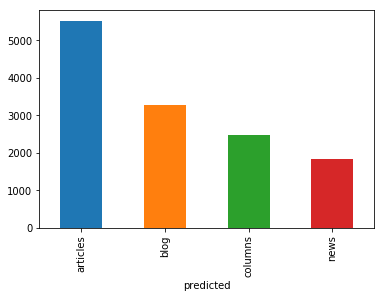

In [31]:
counts = df_ngrams.groupby('predicted').count()['bigram']
counts.plot(kind='bar')

In [44]:
pd.set_option("display.max_rows",500)
df_ngrams[df_ngrams['predicted'] == 'news'].sort_values('news', ascending = False)

,bigram,predicted,articles,blog,columns,news
1645,економічний правда,news,0.000010,1.738641e-07,8.209873e-08,0.999989
169,як повідомлятися,news,0.000026,2.223266e-05,2.659122e-05,0.999926
1317,раніший повідомлятися,news,0.000062,3.905883e-05,2.169608e-05,0.999877
92,"повідомлятися ,",news,0.000034,8.210733e-05,1.479976e-05,0.999869
6483,повідомлятися на,news,0.000042,5.672811e-05,5.644270e-05,0.999844
11,про це,news,0.000076,4.405285e-05,4.852294e-05,0.999831
1290,укрінформ .,news,0.000092,1.048825e-04,1.123613e-04,0.999691
5231,заборонятися також,news,0.000076,1.212252e-04,1.169114e-04,0.999686
9341,повідомлятися про,news,0.000109,1.315621e-04,1.333513e-04,0.999626
4685,дипломат .,news,0.000347,3.991524e-04,4.252486e-04,0.998828


In [46]:
df_ngrams[df_ngrams['predicted'] == 'blog'].sort_values('blog', ascending = False)

,bigram,predicted,articles,blog,columns,news
6401,... а,blog,0.000353,0.997412,0.002046,0.000190
6632,... але,blog,0.000450,0.996937,0.002256,0.000357
4684,... і,blog,0.000315,0.994637,0.004665,0.000383
5891,... я,blog,0.000582,0.993542,0.005052,0.000825
2873,"значить ,",blog,0.005079,0.992419,0.002186,0.000315
9901,"переговори ,",blog,0.005079,0.992419,0.002186,0.000315
12238,... ми,blog,0.000335,0.992323,0.006911,0.000431
11488,... у,blog,0.000335,0.992323,0.006911,0.000431
10907,... це,blog,0.000335,0.992323,0.006911,0.000431
12399,- політичний,blog,0.000748,0.986305,0.001526,0.011420


In [52]:
df_ngrams[df_ngrams['predicted'] == 'columns'].sort_values('columns', ascending = False)

,bigram,predicted,articles,blog,columns,news
4467,зір автор,columns,0.000066,0.000106,0.999718,0.000110
4464,публікація в,columns,0.001007,0.000136,0.998746,0.000111
10106,. автор,columns,0.001408,0.001708,0.995073,0.001811
8391,", автор",columns,0.003235,0.002126,0.992812,0.001827
11176,публікація .,columns,0.038532,0.001065,0.959171,0.001232
5818,часто не,columns,0.060939,0.000773,0.937797,0.000491
4192,редакційний стаття,columns,0.022025,0.019891,0.936376,0.021709
8370,винятково точка,columns,0.027851,0.025201,0.919471,0.027477
6497,відображати винятково,columns,0.027851,0.025201,0.919471,0.027477
8523,часто бути,columns,0.111323,0.005577,0.879625,0.003476


In [54]:
df_ngrams[df_ngrams['predicted'] == 'articles'].sort_values('articles', ascending = False)[0:15]

,bigram,predicted,articles,blog,columns,news
10437,титульний фото,articles,0.913640,0.005867,0.074363,0.006131
5534,дорога .,articles,0.886808,0.007678,0.099529,0.005986
7188,"спецпроект """,articles,0.874648,0.040034,0.075240,0.010078
3435,сенс .,articles,0.861363,0.127179,0.006818,0.004640
6536,фінансування .,articles,0.854689,0.028406,0.053915,0.062990
304,"у """,articles,0.846478,0.095591,0.011904,0.046028
4734,за /,articles,0.840217,0.013723,0.029528,0.116532
12743,сектор .,articles,0.839621,0.010067,0.124097,0.026216
6607,тоді ж,articles,0.836541,0.020849,0.106815,0.035795
1706,", розповідати",articles,0.828527,0.036909,0.048717,0.085847
